In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(linewidth=140)
import pandas as pd; pd.set_option('display.width', 160)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn
import datetime as dt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchinfo


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


# Physio + alternative_imputation + Transformerv2 + VE

```bash
python train_schrodinger_bridge.py --problem-name physio --dataset-missing-ratio 0.5 --physio-nfold 1 \
    --forward-net Unetv2 --backward-net Transformerv2 \
    --train-method alternate_imputation_v2 --num-stage 20 --num-epoch 5 --num-itr 80 --samp-bs 1000 --train-bs-x 10 --train-bs-t 10 --backward-warmup-epoch 120 \
    --sde-type ve --t0 0.001 --sigma-min 0.001 --sigma-max 20.0 --interval 100 \
    --lr-dsm 1e-3 --lr-b 1e-5 --lr-f 1e-5 --l2-norm 1e-5 --ema-decay 0.9 --lr-step 500 \
    --num-eval-sample 100 --imputation-eval --eval-impute-function imputation \
    --notes 'example' --gpu 0
```

In [ ]:
import argparse
import options
import colored_traceback.always
from ipdb import set_trace as debug

problem_name = 'physio'
opt = options.get_default_args(problem_name)
opt.problem_name = problem_name
opt.dataset_missing_ratio = 0.5  # Only for physio dataset.
opt.physio_nfold = 1
timestamp = dt.datetime.now().strftime("%m_%d_%Y_%H%M%S")
opt.forward_net = 'Unetv2'
opt.dataset_missing_ratio = 0.1
opt.backward_net = 'Transformerv2'
opt.train_method = 'alternate_imputation'
opt.sde_type = 've'
opt.sigma_min = 0.001
opt.sigma_max = 20.0
opt.interval = 100
opt.train_bs_x_dsm = 64
opt.train_bs_t_dsm = 1
opt.train_bs_x = 4
opt.train_bs_t = 4
opt.lr_dsm = 1e-3
opt.lr = 1e-4
opt.l2_norm = 1e-6
opt.samp_bs = 500
opt.snapshot_freq = 1
opt.num_eval_sample = 1
opt.ema_decay = 0.98
opt.gpu = 1
opt.notes = 'NULL'
opt.dir = f'{problem_name}_{opt.forward_net}_{opt.backward_net}_{opt.sde_type}_alternate_{timestamp}_{opt.notes}'
opt.ckpt_path = 'results/' + opt.dir
opt = options.post_process_args(opt)

print('-'*40, 'forward net quick I/O test', '-'*40)
from models.Unet.Unetv2 import build_unetv2
net_name = 'Unetv2'
net = build_unetv2(opt.model_configs[net_name], True)
x = torch.randn(64, 1, opt.input_size[0], opt.input_size[1])
t = torch.randint(0, opt.interval, size=(64,))
o = net(x, t)
print(o.shape)

print('-'*40, 'backward net quick I/O test', '-'*40)
from models.Transformer.Transformerv2 import build_transformerv2
net_name = 'Transformerv2'
net = build_transformerv2(opt.model_configs[net_name], opt.interval, False)
total_input = torch.randn(33, 2, opt.input_size[0], opt.input_size[1])
cond_mask = torch.randn(33, 1, opt.input_size[0], opt.input_size[1])
t = torch.randint(0, opt.interval, size=(33,))
diff_input = (total_input, cond_mask)
o = net(diff_input, t)
print(o.shape)


In [ ]:
from runner import Runner
run = Runner(opt)
_=torchinfo.summary(run.z_f, depth=2, verbose=1)
_=torchinfo.summary(run.z_b, depth=2, verbose=1)

In [ ]:
# A short run for sanity check.
rnd_seed = 123
np.random.seed(rnd_seed)
torch.manual_seed(rnd_seed)
torch.use_deterministic_algorithms(False)

opt.DSM_warmup = True
opt.dsm_train_method = 'dsm_imputation_v2'
opt.num_itr_dsm = 50
opt.backward_warmup_epoch = 3
opt.num_stage = 2
opt.num_epoch = 2
opt.num_itr = 50
opt.imputation_eval = True
run.sb_alternate_imputation_train(opt)


## Evaluate
```bash
python train_schrodinger_bridge.py --problem-name physio --dataset-missing-ratio 0.5 --physio-nfold 1 --train-method evaluation \
    --forward-net Unetv2 --backward-net Transformerv2 \
    --sde-type vp_v2 --t0 0.001 --beta-min 0.001 --beta-max 20 --interval 100 \
    --eval-impute-function imputation_vpsde \
    --dir physio_nfold1_MR0.5_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_100511_ICML_eg/ \
    --ckpt-file stage_29_fb.npz \
    --gpu 0
```

##### Restore checkpoints.

In [5]:
import util
ckpt_folder = './results/physio_nfold1_MR0.5_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_100511_ICML_eg/'
ckpt_file = ckpt_folder + 'stage_29_fb.npz'
util.restore_checkpoint(opt, run, ckpt_file)

#loading checkpoint ./results/physio_nfold1_MR0.5_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_100511_ICML_eg/stage_29_fb.npz...
state_dict keys: dict_keys(['z_f', 'optimizer_f', 'ema_f', 'z_b', 'optimizer_b', 'ema_b'])
#successfully loaded all the modules
#loading form ema shadow parameter for polices
#######summary of checkpoint##########


In [6]:
import dataset_physio
train_loader, val_loader, test_loader = dataset_physio.get_dataloader(
    missing_ratio=opt.dataset_missing_ratio, nfold=1, batch_size=64, eval_length=48, target_dim=35,
    device='cpu', seed=1, return_dataset=False)
scaler, mean_scaler = 1.0, 0.0

print(len(train_loader), len(val_loader), len(test_loader))
item = next(iter(val_loader))
print(item.keys()); print(item['observed_data'].shape)

Data path: ./data/physio/physio_missing0.1_seed1.pk
Load existing dataset...
Data path: ./data/physio/physio_missing0.1_seed1.pk
Load existing dataset...
Data path: ./data/physio/physio_missing0.1_seed1.pk
Load existing dataset...
Data path: ./data/physio/physio_missing0.1_seed1.pk
Load existing dataset...
physio nfold1, missing_ratio0.1
train/test/val num samples 2797 401 799
44 7 13
dict_keys(['observed_data', 'observed_mask', 'gt_mask', 'timepoints'])
torch.Size([64, 48, 35])


##### Conditional inference

In [ ]:
from util import conditional_imputation_eval
import runner

output_dir = ckpt_folder
print('save samples to:', ckpt_folder)
opt.permute_batch = True
conditional_imputation_eval('imputation', opt, test_loader, run, mean_scaler=mean_scaler, scaler=scaler,
    num_samples=100, num_eval_batches=None, output_dir=output_dir)

#### Plot saved samples.

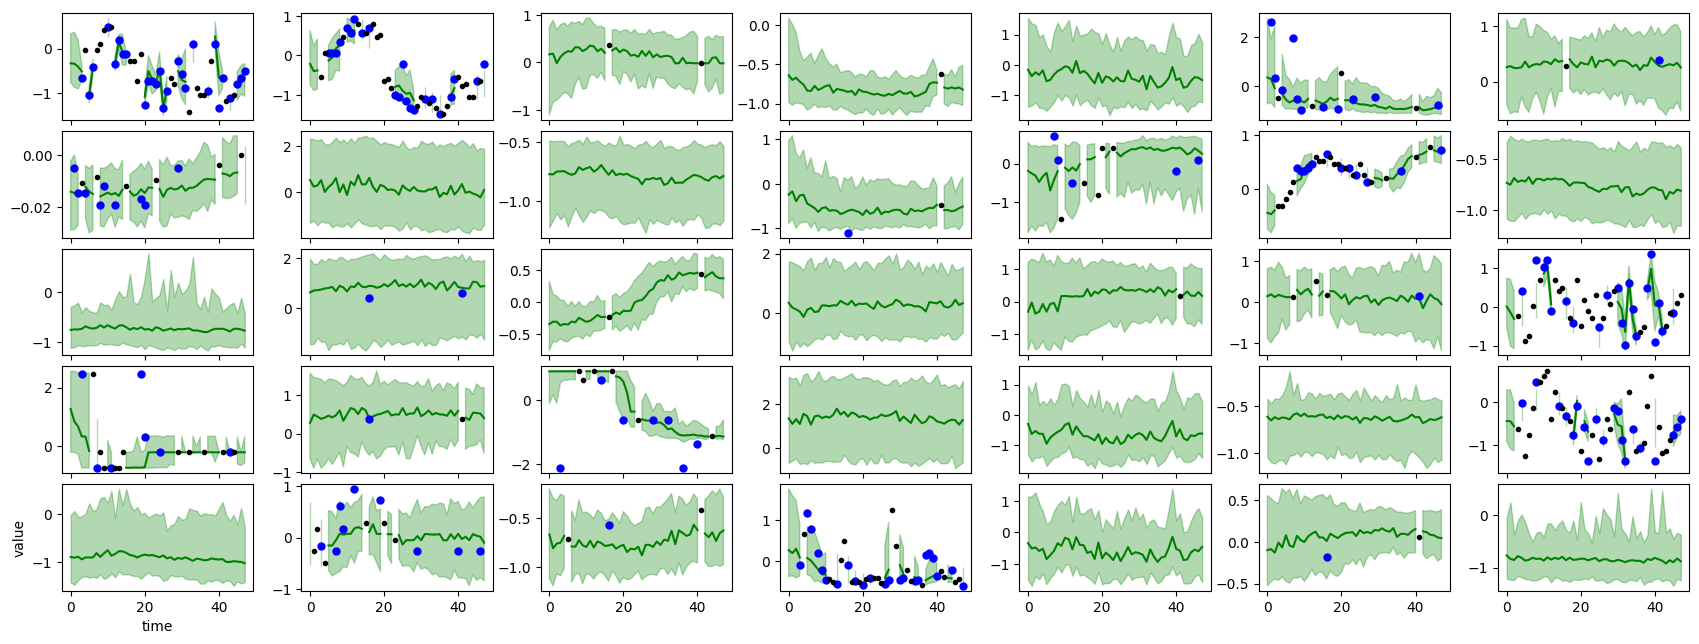

In [10]:
import util
ckpt_dir = './results/physio_nfold1_MR0.5_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_100511_ICML_eg/'
samples_path = ckpt_dir + 'samples100_stageNone_01_23_2023_153146test.pk'
dataind = 7
util.plot_saved_imputation_samples(samples_path, num_cols=7, dataind=dataind)
